In [142]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve
from itertools import combinations, product

from statsmodels.gam.generalized_additive_model import LogitGam

In [143]:
#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#phase_dir = '../phased_ssc.hg38_del'
#assembly = '38'
#sim_file = '../sibpair_similarity/ssc.hg38_identicals.txt'

ped_file = '../../DATA/ihart.ms2/ihart.ped'
phase_dir = '../phased_ihart.ms2_del'
assembly = '38'
sim_file = '../sibpair_similarity/ihart.ms2_del_similarity.txt'

#ped_file = '../../DATA/spark/spark.ped'
#phase_dir = '../phased_spark_del'
#assembly = '38'
#identicals_file = '../sibpair_similarity/spark_quads_identicals.txt'


In [144]:
sibpair_to_sim = dict()
with open(sim_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        sibpair_to_sim[tuple(sorted([pieces[0], pieces[1]]))] = (float(pieces[2]), float(pieces[3]))

In [145]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
in_ped = set()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            #if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                #child_id = ssc_old_id_to_new_id[child_id]
                #f_id = ssc_old_id_to_new_id[f_id]
                #m_id = ssc_old_id_to_new_id[m_id]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

            if f_id != '0' and m_id != '0':
                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
            in_ped.add(m_id)
            in_ped.add(f_id)
            in_ped.add(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [161]:
with open('%s/deletions.json' % phase_dir) as f:
    deletions = json.load(f)

In [147]:
# filter deletions
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

chroms = [str(x) for x in range(1, 23)]
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)


# pull cytobands
intervals = []

with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()

# filter deletions that go through the centromere
centromeres = [x for x in intervals if x[-1] == 'acen']
centromere_deletions = set()
for i, d in enumerate(deletions):
    for chrom, _, start_pos, end_pos, _ in centromeres:
        if d['chrom'] == chrom:
            if d['start_pos'] >= start_pos and d['start_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['end_pos'] >= start_pos and d['end_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                centromere_deletions.add(i)
print('centromere deletions', len(centromere_deletions)) 
deletions = [d for i, d in enumerate(deletions) if i not in centromere_deletions]
print('remaining deletions', len(deletions))


remaining deletions 115706
remaining deletions 115706
centromere deletions 6395
remaining deletions 109311


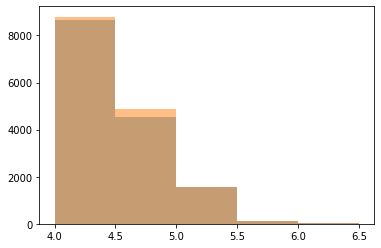

In [162]:
bins=np.arange(4, 7, 0.5)

plt.hist(np.log10([d['length'] for d in deletions if d['is_mat']]), alpha=0.5, bins=bins)
plt.hist(np.log10([d['length'] for d in deletions if d['is_pat']]), alpha=0.5, bins=bins)
plt.show()

In [163]:
sibpair_to_mat_deletions_match, sibpair_to_pat_deletions_match = defaultdict(list), defaultdict(list)
sibpair_to_mat_deletions_nomatch, sibpair_to_pat_deletions_nomatch = defaultdict(list), defaultdict(list)
sibpair_to_mat_deletions_pro, sibpair_to_pat_deletions_pro = defaultdict(list), defaultdict(list)
sibpair_to_mat_deletions_sib, sibpair_to_pat_deletions_sib = defaultdict(list), defaultdict(list)

probands = set()
for fam, inds in fam_to_inds.items():
    aff_children = [x for x in inds[2:] if child_id_to_affected[x]=='2']
    if len(aff_children)>0:
        probands.add(random.choice(aff_children))
print(len(probands))

for d in deletions:
    if d['is_mat']:
        for sib1, sib2 in combinations(d['trans'], 2):
            #if sib1 in probands or sib2 in probands:
            sibpair_to_mat_deletions_match[tuple(sorted([sib1, sib2]))].append(d['length'])
        for sib1, sib2 in product(d['trans'], d['notrans']):
            #if sib1 in probands or sib2 in probands:
            sibpair_to_mat_deletions_nomatch[tuple(sorted([sib1, sib2]))].append(d['length'])
        if len(probands & set(d['trans']))>0:
            sib1 = sorted(probands & set(d['trans']))[0]
            for sib2 in d['notrans']:
                sibpair_to_mat_deletions_pro[tuple(sorted([sib1, sib2]))].append(d['length'])
        if len(probands & set(d['notrans']))>0:
            sib1 = sorted(probands & set(d['notrans']))[0]
            for sib2 in d['trans']:
                sibpair_to_mat_deletions_sib[tuple(sorted([sib1, sib2]))].append(d['length'])
    elif d['is_pat']:
        for sib1, sib2 in combinations(d['trans'], 2):
            #if sib1 in probands or sib2 in probands:
            sibpair_to_pat_deletions_match[tuple(sorted([sib1, sib2]))].append(d['length'])
        for sib1, sib2 in product(d['trans'], d['notrans']):
            #if sib1 in probands or sib2 in probands:
            sibpair_to_pat_deletions_nomatch[tuple(sorted([sib1, sib2]))].append(d['length'])
        
        if len(probands & set(d['trans']))>0:
            sib1 = sorted(probands & set(d['trans']))[0]
            for sib2 in d['notrans']:
                sibpair_to_pat_deletions_pro[tuple(sorted([sib1, sib2]))].append(d['length'])
        if len(probands & set(d['notrans']))>0:
            sib1 = sorted(probands & set(d['notrans']))[0]
            for sib2 in d['trans']:
                sibpair_to_pat_deletions_sib[tuple(sorted([sib1, sib2]))].append(d['length'])

1038


In [164]:
sibpairs = sorted(set(sibpair_to_mat_deletions_match.keys()) & set(sibpair_to_sim.keys()))
print(len(sibpairs))

mat_deletions_match = np.array([sum(sibpair_to_mat_deletions_match[x]) for x in sibpairs])
mat_deletions_nomatch = np.array([sum(sibpair_to_mat_deletions_nomatch[x]) for x in sibpairs])
mat_deletions_pro = np.array([sum(sibpair_to_mat_deletions_pro[x]) for x in sibpairs])
pat_deletions_match = np.array([sum(sibpair_to_pat_deletions_match[x]) for x in sibpairs])
pat_deletions_nomatch = np.array([sum(sibpair_to_pat_deletions_nomatch[x]) for x in sibpairs])
pat_deletions_pro = np.array([sum(sibpair_to_pat_deletions_pro[x]) for x in sibpairs])

mat_count_match = np.array([len(sibpair_to_mat_deletions_match[x]) for x in sibpairs])
mat_count_nomatch = np.array([len(sibpair_to_mat_deletions_nomatch[x]) for x in sibpairs])
pat_count_match = np.array([len(sibpair_to_pat_deletions_match[x]) for x in sibpairs])
pat_count_nomatch = np.array([len(sibpair_to_pat_deletions_nomatch[x]) for x in sibpairs])

mat_sim = np.array([sibpair_to_sim[x][0] for x in sibpairs])
pat_sim = np.array([sibpair_to_sim[x][1] for x in sibpairs])



1644


In [165]:
mat_has_data = mat_deletions_match+mat_deletions_nomatch>0
pat_has_data = pat_deletions_match+pat_deletions_nomatch>0

mat_jaccard = mat_deletions_match/(mat_deletions_match+mat_deletions_nomatch)
pat_jaccard = pat_deletions_match/(pat_deletions_match+pat_deletions_nomatch)

mat_jaccard_pro = mat_deletions_pro/(mat_deletions_match+mat_deletions_nomatch)
pat_jaccard_pro = pat_deletions_pro/(pat_deletions_match+pat_deletions_nomatch)



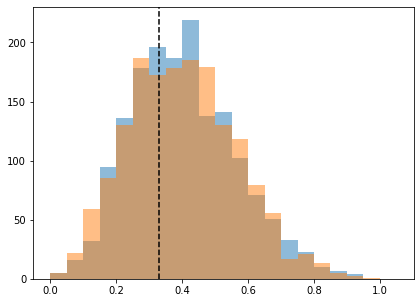

In [166]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(mat_jaccard[mat_has_data], bins=np.arange(0, 1.1, 0.05), alpha=0.5)
plt.hist(pat_jaccard[pat_has_data], bins=np.arange(0, 1.1, 0.05), alpha=0.5)
plt.axvline(0.33, color='black', linestyle='--')

plt.show()

In [167]:
is_aut_aut = np.array([child_id_to_affected[sib1]=='2' and child_id_to_affected[sib2]=='2' for sib1, sib2 in sibpairs])
is_aut_nt = np.array([(child_id_to_affected[sib1]=='2' and child_id_to_affected[sib2]=='1') or (child_id_to_affected[sib1]=='1' and child_id_to_affected[sib2]=='2') for sib1, sib2 in sibpairs])
is_nt_nt = np.array([child_id_to_affected[sib1]=='1' and child_id_to_affected[sib2]=='1' for sib1, sib2 in sibpairs])

print(np.sum(is_aut_aut), np.sum(is_aut_nt), np.sum(is_nt_nt))

910 710 24


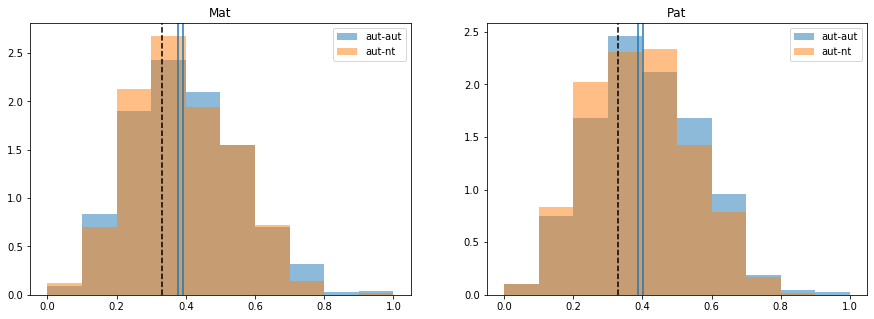

In [154]:
bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Mat')
plt.hist(mat_jaccard[mat_has_data & is_aut_aut], bins=bins, alpha=0.5, density=True, label='aut-aut')
plt.hist(mat_jaccard[mat_has_data & is_aut_nt], bins=bins, alpha=0.5, density=True, label='aut-nt')
#plt.hist(mat_jaccard[mat_has_data & is_nt_nt], bins=bins, alpha=0.5, density=True, label='nt-nt')
plt.axvline(0.33, color='black', linestyle='--')
plt.axvline(np.median(mat_jaccard[mat_has_data & is_aut_aut]))
plt.axvline(np.median(mat_jaccard[mat_has_data & is_aut_nt]))
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Pat')
plt.hist(pat_jaccard[pat_has_data & is_aut_aut], bins=bins, alpha=0.5, density=True, label='aut-aut')
plt.hist(pat_jaccard[pat_has_data & is_aut_nt], bins=bins, alpha=0.5, density=True, label='aut-nt')
#plt.hist(pat_jaccard[pat_has_data & is_nt_nt], bins=bins, alpha=0.5, density=True, label='nt-nt')
plt.axvline(0.33, color='black', linestyle='--')
plt.axvline(np.median(pat_jaccard[pat_has_data & is_aut_aut]))
plt.axvline(np.median(pat_jaccard[pat_has_data & is_aut_nt]))
plt.legend()


plt.show()

In [155]:
print(np.median(mat_jaccard[mat_has_data & is_aut_aut]),
      np.median(mat_jaccard[mat_has_data & is_aut_nt]))

# ihart 0.396382298947963 0.37849602808711624

0.39127792524375415 0.3773135148556861


In [156]:
X = np.vstack((mat_sim, pat_sim, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt), :]
#X = np.vstack((mat_jaccard_count, pat_jaccard_count, np.ones((len(sibpairs), )))).T[is_aut_aut | is_aut_nt, :]
y = is_aut_aut[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt)]
print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


(1620, 3) (1620,)
910 1620
Optimization terminated successfully.
         Current function value: 0.684628
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1620
Model:                          Logit   Df Residuals:                     1617
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Jul 2021   Pseudo R-squ.:                0.001282
Time:                        07:48:55   Log-Likelihood:                -1109.1
converged:                       True   LL-Null:                       -1110.5
Covariance Type:            nonrobust   LLR p-value:                    0.2408
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0744      1.091      0.985      0.325      -1.064       3.213
x2

In [157]:
X = np.vstack((mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt), :]
#X = np.vstack((mat_jaccard_count, pat_jaccard_count, np.ones((len(sibpairs), )))).T[is_aut_aut | is_aut_nt, :]
y = is_aut_aut[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt)]
print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


(1620, 3) (1620,)
910 1620
Optimization terminated successfully.
         Current function value: 0.683409
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1620
Model:                          Logit   Df Residuals:                     1617
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Jul 2021   Pseudo R-squ.:                0.003060
Time:                        07:48:57   Log-Likelihood:                -1107.1
converged:                       True   LL-Null:                       -1110.5
Covariance Type:            nonrobust   LLR p-value:                   0.03342
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4965      0.332      1.495      0.135      -0.155       1.148
x2

In [158]:
X = np.vstack((mat_sim, pat_sim, mat_jaccard, pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt), :]
#X = np.vstack((mat_jaccard_count, pat_jaccard_count, np.ones((len(sibpairs), )))).T[is_aut_aut | is_aut_nt, :]
y = is_aut_aut[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt)]
print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


(1620, 5) (1620,)
910 1620
Optimization terminated successfully.
         Current function value: 0.683173
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1620
Model:                          Logit   Df Residuals:                     1615
Method:                           MLE   Df Model:                            4
Date:                Sat, 03 Jul 2021   Pseudo R-squ.:                0.003405
Time:                        07:49:00   Log-Likelihood:                -1106.7
converged:                       True   LL-Null:                       -1110.5
Covariance Type:            nonrobust   LLR p-value:                    0.1090
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7468      1.141      0.655      0.513      -1.489       2.983
x2

In [159]:
X = np.vstack((mat_sim+pat_sim, mat_jaccard+pat_jaccard, np.ones((len(sibpairs), )))).T[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt), :]
#X = np.vstack((mat_jaccard_count, pat_jaccard_count, np.ones((len(sibpairs), )))).T[is_aut_aut | is_aut_nt, :]
y = is_aut_aut[mat_has_data & pat_has_data & (is_aut_aut | is_aut_nt)]
print(X.shape, y.shape)
print(np.sum(y), len(y))

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


(1620, 3) (1620,)
910 1620
Optimization terminated successfully.
         Current function value: 0.683228
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1620
Model:                          Logit   Df Residuals:                     1617
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Jul 2021   Pseudo R-squ.:                0.003325
Time:                        07:49:02   Log-Likelihood:                -1106.8
converged:                       True   LL-Null:                       -1110.5
Covariance Type:            nonrobust   LLR p-value:                   0.02491
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5905      0.667      0.885      0.376      -0.717       1.898
x2

(0.284693380350897, 5.004670155015714e-32)
(0.3759567280207717, 2.4168709688662687e-56)
(0.01570629388589202, 0.5245245351599552)
(0.006122739583781762, 0.8040819855608495)


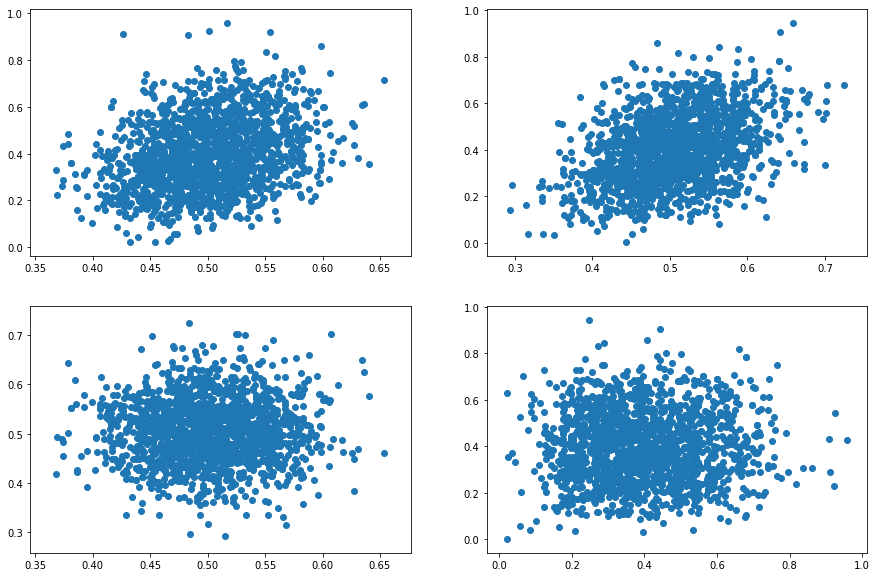

In [160]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(mat_sim, mat_jaccard)
print(stats.pearsonr(mat_sim, mat_jaccard))

plt.subplot(2, 2, 2)
plt.scatter(pat_sim, pat_jaccard)
print(stats.pearsonr(pat_sim, pat_jaccard))

plt.subplot(2, 2, 3)
plt.scatter(mat_sim, pat_sim)
print(stats.pearsonr(mat_sim, pat_sim))

plt.subplot(2, 2, 4)
plt.scatter(mat_jaccard, pat_jaccard)
print(stats.pearsonr(mat_jaccard, pat_jaccard))

plt.show()

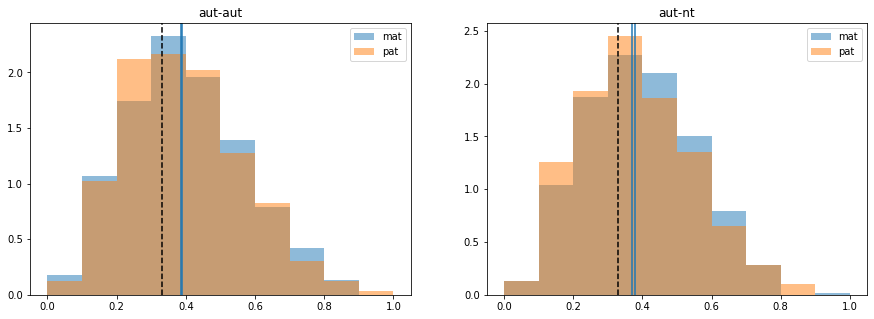

In [128]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('aut-aut')
plt.hist(mat_jaccard[mat_has_data & is_aut_aut], bins=np.arange(0, 1.1, 0.1), alpha=0.5, density=True, label='mat')
plt.hist(pat_jaccard[pat_has_data & is_aut_aut], bins=np.arange(0, 1.1, 0.1), alpha=0.5, density=True, label='pat')
#plt.hist(mat_jaccard[mat_has_data & is_nt_nt], bins=np.arange(0, 1.1, 0.1), alpha=0.5, density=True, label='nt-nt')
plt.axvline(0.33, color='black', linestyle='--')
plt.axvline(np.median(mat_jaccard[mat_has_data & is_aut_aut]))
plt.axvline(np.median(mat_jaccard[mat_has_data & is_aut_nt]))
plt.legend()

plt.subplot(1, 2, 2)
plt.title('aut-nt')
plt.hist(mat_jaccard[mat_has_data & is_aut_nt], bins=np.arange(0, 1.1, 0.1), alpha=0.5, density=True, label='mat')
plt.hist(pat_jaccard[pat_has_data & is_aut_nt], bins=np.arange(0, 1.1, 0.1), alpha=0.5, density=True, label='pat')
#plt.hist(pat_jaccard[pat_has_data & is_nt_nt], bins=np.arange(0, 1.1, 0.1), alpha=0.5, density=True, label='nt-nt')
plt.axvline(0.33, color='black', linestyle='--')
plt.axvline(np.median(pat_jaccard[pat_has_data & is_aut_aut]))
plt.axvline(np.median(pat_jaccard[pat_has_data & is_aut_nt]))
plt.legend()

plt.show()